In [ ]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
bandit_difficulty = 'easy'
PLAYGROUND_DIR = f"~/logs/EI_RLDM/bandit/{bandit_difficulty}"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"
num_episodes = 1000  # Adjust based on training Episodes
num_episodes_colei = 1000
batch_size = 256
n_seeds = 20
grad_clip_list = [1]
rad_list = [1.]
lr_list = [None]
seeds = [i for i in range(n_seeds)]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(_, _, _, rad, ei_ratio) = para_comb[0]
learning_rates = { "rnn": 1.5e-3,
    "colei": 1e-3,
    "colei_ii": 6e-4,
    "danns": 2e-3
    }

grad_clips = { "rnn": 1,
    "colei": 1,
     "colei_ii": 5,
    "danns": 1
    }
# Initialize dictionaries to store losses
models = {
    "rnn": {}, 
    "colei": {},
    "colei_ii": {},
    "danns": {}
}
n_hidden = 48
test_batch_size = 150
num_batches = 1 
num_trials_per_ep = 100
test_num_trials = 100

In [ ]:
for model_type in models.keys():
    learning_rate = learning_rates[model_type]
    grad_clip = grad_clips[model_type]
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    models[model_type] = {k: np.zeros((n_seeds, num_episodes_p)) for k in ["regret", "train_loss", "num_suboptimal_pulls"]}
    models[model_type]["regret_trials"] = np.zeros((n_seeds, num_episodes_p, test_num_trials))
    for seed in seeds:
        if model_type == "colei_ii":
            ablate_ii = True
            model_type_prov = "colei"
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type_prov}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_ablate_ii{ablate_ii}_adam.npz"
        elif model_type == "colei":
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{(rad)}_lr{learning_rate}_GC{grad_clip}_adam.npz"
        elif model_type == 'rnn':
                 results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_adam.npz"
        else:
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/bandit_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_adam.npz"
            
        if os.path.exists(results_path):
            data = np.load(results_path, allow_pickle=True)
            try:
                models[model_type]["train_loss"][seed, :] = data["train_loss"][:num_episodes_p]
                models[model_type]["regret"][seed, :] = data["regret"][:num_episodes_p]
                models[model_type]["num_suboptimal_pulls"][seed, :] = data["num_suboptimal_pulls"][:num_episodes_p]
                models[model_type]["regret_trials"][seed, :num_episodes_p, :] = np.stack(data['regret_trials'][:num_episodes_p])
            except Exception as e:
                print(e, results_path)
        else:
            print(f"Warning: Missing file {results_path}")

In [61]:
def exp_avg_convolve(arr, alpha):
    kernel = (1 - alpha) ** np.arange(len(arr))
    kernel /= kernel.sum()
    return np.convolve(arr, kernel, mode='full')[:len(arr)]

In [ ]:
# Compute mean and standard deviation across seeds
train_loss_mean = {model: np.mean(models[model]["train_loss"], axis=0) for model in models}
train_loss_std = {model: np.std(models[model]["train_loss"], axis=0, ddof=1)/np.sqrt(n_seeds) for model in models}num_suboptimal_pulls_mean2 = {model: np.mean(np.array([models[model]["regret"][seed] for seed in seeds]), axis=0) for model in models} 
num_suboptimal_pulls_std2 = {model: np.std(np.array([models[model]["regret"][seed] for seed in seeds]), axis=0) for model in models} 

regret_mean = {model: np.mean(models[model]["regret"], axis=0) for model in models}
regret_std = {model: np.std(models[model]["regret"], axis=0, ddof=1)/n_seeds for model in models}
regret_mean2 = {model: np.mean(np.array([exp_avg_convolve(models[model]["regret"][seed], 0.1) for seed in seeds]), axis=0) for model in models} 
regret_std2 = {model: np.std(np.array([exp_avg_convolve(models[model]["regret"][seed], 0.1) for seed in seeds]), axis=0, ddof=1)/np.sqrt(n_seeds) for model in models} 

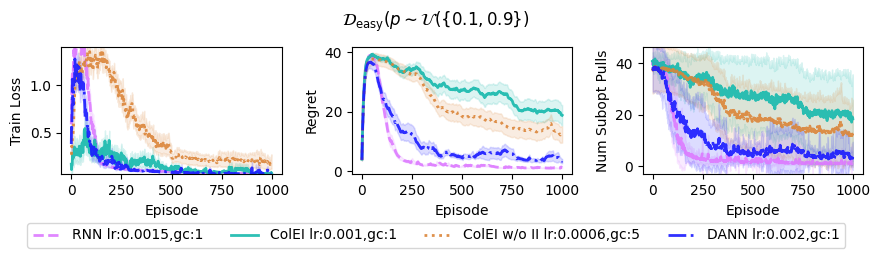

In [63]:
# Plot results
labels = {"rnn": "RNN",
          "colei": "ColEI",
           "colei_ii": "ColEI w/o II", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:4]) for color in COLORS]
COLORS = plt.get_cmap('Set1').colors
linestyles = ['--',  '-',':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:4]) for color in COLORS]
colors = ["#dd7aff", "#17b9ad", "#db8539","#1a1aff" ]


fig, axes = plt.subplots(1, 3, figsize=(9, 2.5), squeeze=False)
# axes[2, 1].sharey(axes[2, 0])  # Share y-axis only in the second row
# Training Loss


### Train Loss ###
all_loss_values = []
for i, model_type in enumerate(models.keys()):
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    loss_values = train_loss_mean[model_type]
    std_values = train_loss_std[model_type]
    loss_values = np.nan_to_num(loss_values, nan=0)
    std_values = np.nan_to_num(std_values, nan=0)

    all_loss_values.extend(loss_values - std_values)
    all_loss_values.extend(loss_values + std_values)

    axes[0, 0].plot(loss_values, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    
    axes[0, 0].fill_between(range(num_episodes_p), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Train Loss")
# axes[0, 0].legend()

all_loss_values = np.nan_to_num(all_loss_values, nan=0)
y_min, y_max = np.percentile(all_loss_values, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)


### Test Loss ###
all_test_loss_values = []
for i, model_type in enumerate(models.keys()):
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    loss_values = regret_mean2[model_type]
    std_values = regret_std2[model_type]

    all_test_loss_values.extend(loss_values - std_values)
    all_test_loss_values.extend(loss_values + std_values)

    axes[0, 1].plot(loss_values,  color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 1].fill_between(range(num_episodes_p), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 1].set_xlabel("Episode")
axes[0, 1].set_ylabel("Regret")


### Test Loss ###
all_num_suboptimal_pulls_values = []
for i, model_type in enumerate(models.keys()):
    if model_type == "colei":
        num_episodes_p = num_episodes_colei
    else:
        num_episodes_p = num_episodes
    loss_values = num_suboptimal_pulls_mean2[model_type]
    std_values = num_suboptimal_pulls_std2[model_type]

    all_num_suboptimal_pulls_values.extend(loss_values - std_values)
    all_num_suboptimal_pulls_values.extend(loss_values + std_values)

    axes[0, 2].plot(loss_values,  color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 2].fill_between(range(len(loss_values)), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 2].set_xlabel("Episode")
axes[0, 2].set_ylabel("Num Subopt Pulls")

# axes[0, 1].legend()

y_min, y_max = np.percentile(all_num_suboptimal_pulls_values, [1, 99])
axes[0, 2].set_ylim(y_min, y_max)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.05))
fig.suptitle(r"$\mathcal{D}_{\mathrm{easy}} (p \sim \mathcal{U}(\{0.1,0.9\})$", y=0.93)
# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

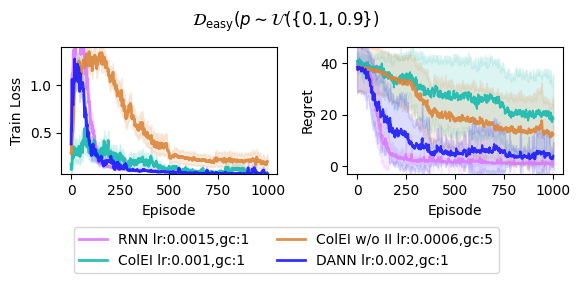

In [ ]:
# Plot results
labels = {"rnn": "RNN",
          "colei": "ColEI",
           "colei_ii": "ColEI w/o II", 
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['-', '--', ':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:4]) for color in COLORS]
COLORS = plt.get_cmap('Set1').colors
# linestyles = ['--',  '-',':', '-.', '--', ':', '-.', (0, (5, 2))]
linestyles = ['-',  '-','-', '-', '-', '-', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:4]) for color in COLORS]
colors = ["#dd7aff", "#17b9ad", "#db8539","#1a1aff" ]

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), squeeze=False)
# axes[2, 1].sharey(axes[2, 0])  # Share y-axis only in the second row
# Training Loss


### Train Loss ###
all_loss_values = []
for i, model_type in enumerate(models.keys()):
    loss_values = train_loss_mean[model_type][:num_episodes]
    std_values = train_loss_std[model_type][:num_episodes]
    loss_values = np.nan_to_num(loss_values, nan=0)
    std_values = np.nan_to_num(std_values, nan=0)

    all_loss_values.extend(loss_values - std_values)
    all_loss_values.extend(loss_values + std_values)

    axes[0, 0].plot(loss_values, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i],  lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    
    axes[0, 0].fill_between(range(num_episodes), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Train Loss")
# axes[0, 0].legend()

all_loss_values = np.nan_to_num(all_loss_values, nan=0)
y_min, y_max = np.percentile(all_loss_values, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)


### Test Loss ###
all_test_loss_values = []
for i, model_type in enumerate(models.keys()):
    
    loss_values = num_suboptimal_pulls_mean2[model_type][:num_episodes]
    std_values = num_suboptimal_pulls_std2[model_type][:num_episodes]

    all_test_loss_values.extend(loss_values - std_values)
    all_test_loss_values.extend(loss_values + std_values)

    axes[0, 1].plot(loss_values,  color=colors[i],  lw=1.5, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 1].fill_between(range(num_episodes), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 1].set_xlabel("Episode")
axes[0, 1].set_ylabel("Regret")
# axes[0, 1].legend()

y_min, y_max = np.percentile(all_test_loss_values, [1, 99])
axes[0, 1].set_ylim(y_min, y_max)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=len(unique_labels)//2, bbox_to_anchor=(0.5, -0.15))
fig.suptitle(r"$\mathcal{D}_{\mathrm{easy}} (p \sim \mathcal{U}(\{0.1,0.9\})$", y=0.93)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()